(RM07)=
# RM07

## Non-linear classification

See also [exercise RM06](RM06) {cite}`Boyd2004` (chapter 8.6).

### Creation of labeled measurements ("training data")

Create $m$ random data pairs $(w_i, l_i)$ of weights and lengths.

In [1]:
m = 300;
w = rand(m,1);  % weight
l = rand(m,1);  % length

Split the measurements into two sets according to a non-linear function
(in this case an unit circle),
such that a data pair $(w_i, l_i)$ is considered as **"good"** for $1 \leq i \leq k \leq m$
and **"bad"** otherwise.

In [2]:
idx = sqrt (w .^ 2 + l.^2) < 1;
k = sum(idx);
w = [w(idx); w(~idx)];
l = [l(idx); l(~idx)];

Plot the resulting data to discriminate.

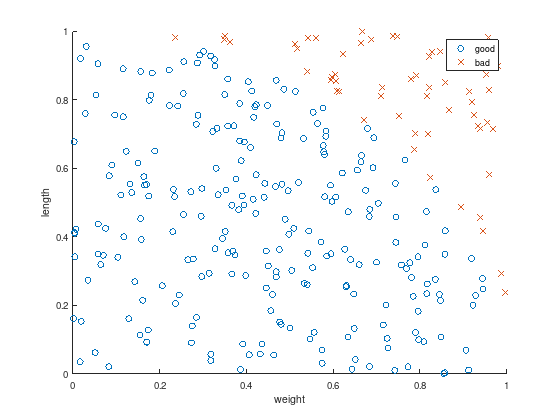

In [3]:
axis equal
scatter(w(1:k),   l(1:k),   'o');  % good
hold on;
scatter(w(k+1:m), l(k+1:m), 'x');  % bad
xlabel('weight');
ylabel('length');
legend ({'good', 'bad'});

### Classification

It is obvious,
that linear discrimination fails.
There exists no linear function

$$
f_{\text{linear}}(w_i,l_i)
= x_0 + \begin{pmatrix} x_1 \\ x_2 \end{pmatrix}^{T} \begin{pmatrix} w_i \\ l_i \end{pmatrix}
= x_0 + x_1 \cdot w_i + x_2 \cdot l_i
$$

to seperate
- the **"good"** blue cicles: $f_{\text{linear}}(w_i,l_i) \leq -1$ for $1 \leq i \leq k \leq m$ and
- the **"bad"** red crosses: $f_{\text{linear}}(w_i,l_i) \geq 1$ for $k < i \leq m$.

However,
using a quadratic discrimination function will work in this example:

$$
\begin{aligned}
f_{\text{quad}}(w_i,l_i)
&= x_0 + \begin{pmatrix} x_1 \\ x_2 \end{pmatrix}^{T} \begin{pmatrix} w_i \\ l_i \end{pmatrix}
 + \begin{pmatrix} w_i \\ l_i \end{pmatrix}^{T} \begin{pmatrix} x_4 & x_3 \\ x_3 & x_5 \end{pmatrix}
   \begin{pmatrix} w_i \\ l_i \end{pmatrix} \\
&= x_0 + x_1 \cdot w_i + x_2 \cdot l_i + 2 x_3 \cdot w_i \cdot l_i
 + x_4 \cdot w_i^2 + x_5 \cdot l_i^2
\end{aligned}
$$

Roughly speaking,
the quadratic discrimination function maps the data into higher dimensions **(expanded measurement vector)**
and projects it to a scalar value.
The optimization problem becomes finding a separating hyperplane in the expanded measurement vector,
which is a linear classifier with the parameters $x_0$ to $x_5$.
This technique has been used in extending **neural network models for pattern recognition**.

To illustrate the approach,
consider the squared sum of the test data's weights and lengths:

$$
f_{wl}(i) = w_i^2 + l_i^2,
$$

with $1 \leq i \leq m$.

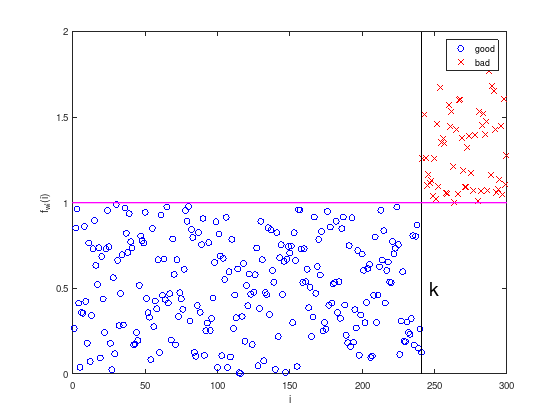

In [4]:
axis equal
plot (1:k,   w(1:k) .^ 2   + l(1:k) .^ 2,   'bo');  % good
hold on;
plot (k+1:m, w(k+1:m) .^ 2 + l(k+1:m) .^ 2, 'rx');  % bad
plot ([k,k],[0,2], 'k', 'LineWidth', 1);
plot ([0,m],[1,1], 'm', 'LineWidth', 2);
text (k + 5, 0.5, 'k', 'FontSize', 20);
xlabel('i')
ylabel('f_{wl}(i)')
legend ({'good', 'bad'})

Regarding the construction of the data set above,
it is no surprise that $f_{wl}(i) = w_i^2 + l_i^2 = 1$ is a separating hyperplane.

### Feasibility problem as Linear Program (LP)

For now let's pretend,
that the structure of the measurements (test data) is not known,
and a general quadratic classifier is sought.

Like in [exercise RM05](RM05) this optimization problem
can be formulated as LP on the expanded measurement vector:

$$
\begin{array}{lrll}
\textrm{minimize}   & \begin{pmatrix} 0 & 0 & 0 & 0 & 0 & 0 \end{pmatrix} & x & \\
\textrm{subject to} &
\begin{pmatrix}
1 & w_i & l_i & 2 w_i l_i & w_i^2 & l_i^2
\end{pmatrix}
& x \leq -1, & i = 1, \ldots, k, \\
& -\begin{pmatrix}
1 & w_i & l_i & 2 w_i l_i & w_i^2 & l_i^2
\end{pmatrix}
& x \leq -1, & i = k + 1, \ldots, m,
\end{array}
$$

In [5]:
c = [0 0 0 0 0 0];
A = [ ones(k,  1),  w(1:k),    l(1:k),    2.*w(1:k)  .*l(1:k),    w(1:k)  .^2,  l(1:k)  .^2; ...
     -ones(m-k,1), -w(k+1:m), -l(k+1:m), -2.*w(k+1:m).*l(k+1:m), -w(k+1:m).^2, -l(k+1:m).^2 ];
b = -ones(m,1);
Aeq = []; % No equality constraints
beq = [];
lb = -inf(6,1);  % x0 to x5 are free variables
ub =  inf(6,1);
CTYPE = repmat ('U', m, 1);  % Octave: A(i,:)*x <= b(i)
x0 = [];  % default start value
%[x,~,exitflag] = linprog(c,A,b,Aeq,beq,lb,ub,x0);  % Matlab: exitflag=1 success
[x,~,exitflag] = glpk(c,A,b,lb,ub,CTYPE)            % Octave: exitflag=0 success

x =

     6.6295
  -113.1690
  -171.7719
    57.0760
   115.8150
   162.4596

exitflag = 0


The computed solution differs from the unit circle,
but nevertheless perfectly discriminates the test data
and a quadratic classifier is found
without prior knowledge of the test data structure.

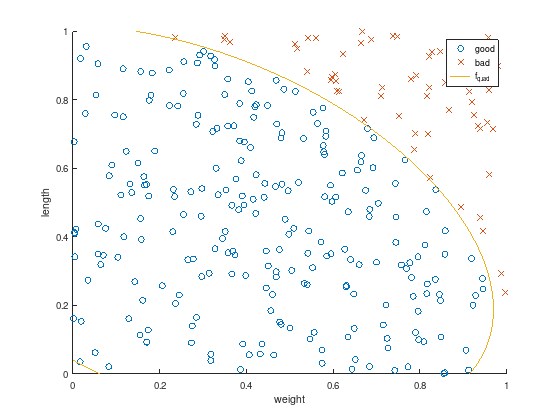

In [6]:
axis equal
scatter(w(1:k),   l(1:k),   'o');  % good
hold on;
scatter(w(k+1:m), l(k+1:m), 'x');  % bad

f_quad = @(w,l) 1.*x(1) + w.*x(2) + l.*x(3) + 2.*w.*l.*x(4) + w.^2.*x(5) + l.^2.*x(6);
ezplot (f_quad, [0,1,0,1]);

title ('');
xlabel('weight');
ylabel('length');
legend ({'good', 'bad', 'f_{quad}'});

The quadratic discrimination function $f_{quad}(w,l)$ maps all data into higher dimensions
and projects it to a scalar value to distinguish "good" and "bad" data pairs.

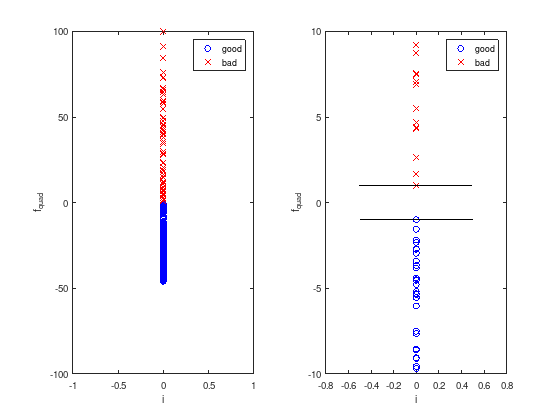

In [7]:
subplot (1, 2, 1)
plot (zeros(k,1),   f_quad(w(1:k),   l(1:k)),   'bo');  % good
hold on;
plot (zeros(m-k,1), f_quad(w(k+1:m), l(k+1:m)), 'rx');  % bad
xlabel('i')
ylabel('f_{quad}')
legend ({'good', 'bad'})
ylim ([-100 100]);

subplot (1, 2, 2)
plot (zeros(k,1),   f_quad(w(1:k),   l(1:k)),   'bo');  % good
hold on;
plot (zeros(m-k,1), f_quad(w(k+1:m), l(k+1:m)), 'rx');  % bad
plot ([-0.5, 0.5],  [1, 1], 'k');
plot ([-0.5, 0.5], -[1, 1], 'k');
xlabel('i')
ylabel('f_{quad}')
legend ({'good', 'bad'})
ylim ([-10 10]);

After this "training" the discrimination function can be used to classify other data pairs as well.